Using device: cuda

Epoch 1/50
 [██████████████████████████████] 100.0%
Train Loss: 110.0447 | Train Acc: 0.5976
Validation Acc: 0.6064

Epoch 2/50
 [██████████████████████████████] 100.0%
Train Loss: 106.7173 | Train Acc: 0.6251
Validation Acc: 0.6307

Epoch 3/50
 [██████████████████████████████] 100.0%
Train Loss: 106.4136 | Train Acc: 0.6262
Validation Acc: 0.6385

Epoch 4/50
 [██████████████████████████████] 100.0%
Train Loss: 106.2564 | Train Acc: 0.6280
Validation Acc: 0.6391

Epoch 5/50
 [██████████████████████████████] 100.0%
Train Loss: 105.8781 | Train Acc: 0.6317
Validation Acc: 0.6258

Epoch 6/50
 [██████████████████████████████] 100.0%
Train Loss: 105.0284 | Train Acc: 0.6375
Validation Acc: 0.6226

Epoch 7/50
 [██████████████████████████████] 100.0%
Train Loss: 102.9695 | Train Acc: 0.6523
Validation Acc: 0.6869

Epoch 8/50
 [██████████████████████████████] 100.0%
Train Loss: 98.3954 | Train Acc: 0.6868
Validation Acc: 0.7139

Epoch 9/50
 [██████████████████████████████] 

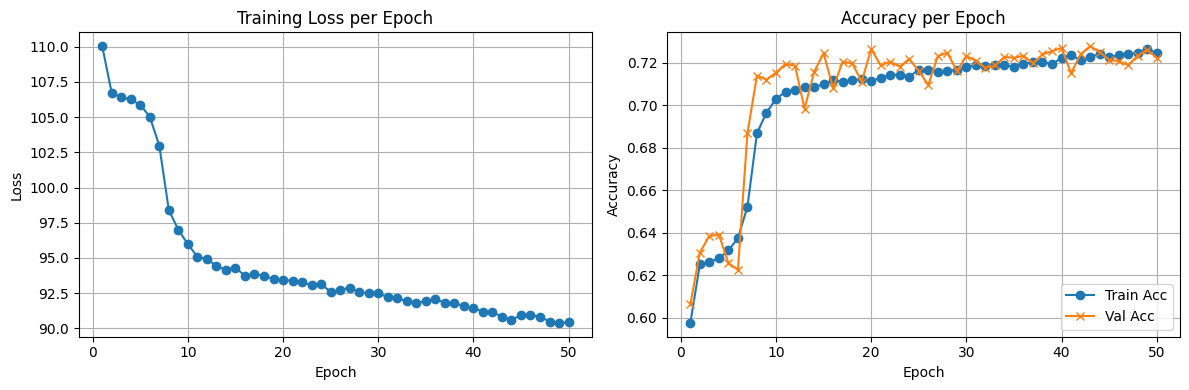

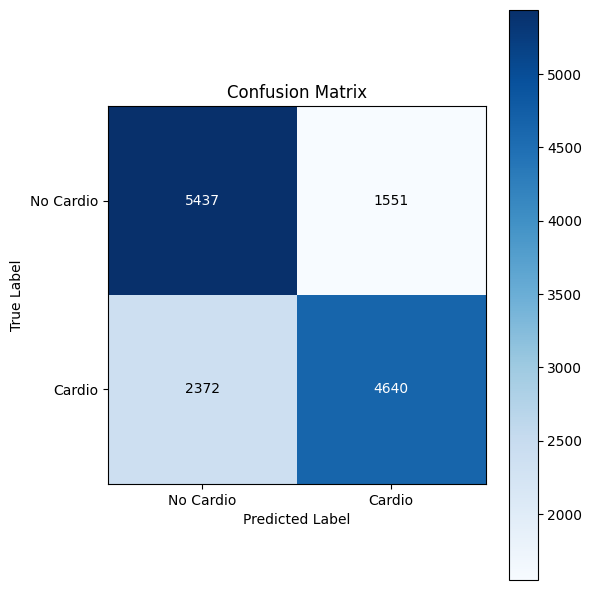

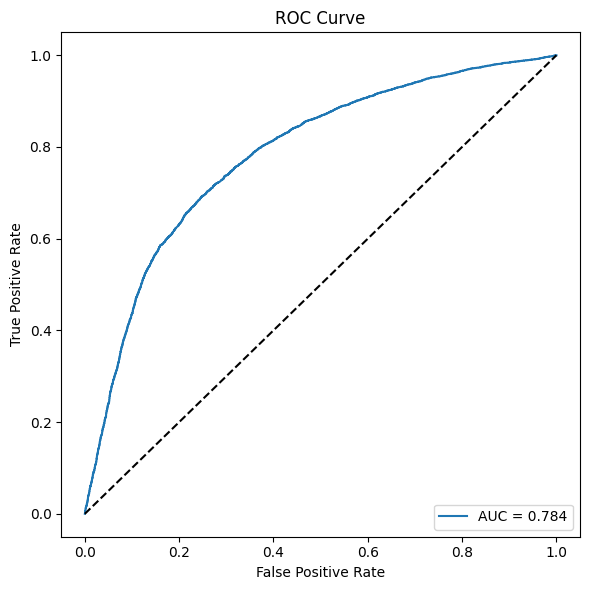

In [8]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from tab_transformer_pytorch import TabTransformer
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, roc_curve, confusion_matrix
)
import numpy as np
import matplotlib.pyplot as plt
import sys

# --------------------------------------------
# 0. デバイス設定
# --------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --------------------------------------------
# 1. データ読み込み
# --------------------------------------------
data = pd.read_csv("cardio_train.csv", sep=';')

# BMI = 体重(kg) / (身長(m))^2
#  → data['weight'] (kg)、data['height'] (cm) を使う
data['BMI'] = data['weight'] / ((data['height'] / 100) ** 2)

# 年齢 age は日単位と仮定 → 年単位に変換して整数化
data['age_years'] = (data['age'] / 365).astype(int)

# --------------------------------------------
# 2. 特徴量指定
# --------------------------------------------
categorical_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
continuous_cols  = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 'BMI']
target_col       = 'cardio'

# --------------------------------------------
# 3. カテゴリ変数を数値化（LabelEncoder）
# --------------------------------------------
for col in categorical_cols:
    data[col] = LabelEncoder().fit_transform(data[col])

# --------------------------------------------
# 4. 連続変数を標準化（平均0, 標準偏差1）
# --------------------------------------------
scaler = StandardScaler()
data[continuous_cols] = scaler.fit_transform(data[continuous_cols])

# --------------------------------------------
# 5. 訓練/検証/テスト分割 3:1:1
# --------------------------------------------
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data      = train_test_split(train_val_data, test_size=0.25, random_state=42)
# train_data: 0.6, val_data: 0.2, test_data: 0.2

# --------------------------------------------
# 6. PyTorch Dataset クラス定義
# --------------------------------------------
class CardioDataset(Dataset):
    def __init__(self, df):
        self.categ  = df[categorical_cols].values.astype(np.int64)
        self.cont   = df[continuous_cols].values.astype(np.float32)
        self.labels = df[target_col].values.astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.categ[idx]),
            torch.tensor(self.cont[idx]),
            torch.tensor(self.labels[idx])
        )

# DataLoader の準備
train_loader = DataLoader(CardioDataset(train_data), batch_size=256, shuffle=True)
val_loader   = DataLoader(CardioDataset(val_data),   batch_size=256)
test_loader  = DataLoader(CardioDataset(test_data),  batch_size=256)

# --------------------------------------------
# 7. TabTransformer モデル構築
# --------------------------------------------
cont_mean_std = torch.tensor([[0., 1.]] * len(continuous_cols)).to(device)
model = TabTransformer(
    categories=tuple(data[col].nunique() for col in categorical_cols),
    num_continuous=len(continuous_cols),
    dim=32,
    dim_out=1,
    depth=4,
    heads=4,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2),
    mlp_act=nn.ReLU(),
    continuous_mean_std=cont_mean_std
).to(device)
model.categories_offset = model.categories_offset.to(device)

# --------------------------------------------
# 8. 損失関数 & 最適化手法
# --------------------------------------------
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

# --------------------------------------------
# 9. 学習ループ（早期停止付き）
# --------------------------------------------
def train_with_validation(model, train_loader, val_loader, epochs, threshold):
    model.train()
    loss_history      = []
    train_acc_history = []
    val_acc_history   = []
    total_batches     = len(train_loader)

    for epoch in range(epochs):
        total_loss = 0.0
        correct, total = 0, 0
        print(f"\nEpoch {epoch+1}/{epochs}")

        # --- 訓練フェーズ ---
        for batch_idx, (x_categ, x_cont, y) in enumerate(train_loader):
            x_categ, x_cont, y = x_categ.to(device), x_cont.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x_categ, x_cont).squeeze(1)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # 訓練精度計算
            prob = torch.sigmoid(out)
            pred = (prob > 0.5).int()
            correct += (pred == y.int()).sum().item()
            total += y.size(0)

            # 進捗バー
            progress = (batch_idx + 1) / total_batches * 100
            bar_len = 30
            filled = int(bar_len * progress / 100)
            bar = '█' * filled + '-' * (bar_len - filled)
            sys.stdout.write(f"\r [{bar}] {progress:5.1f}%")
            sys.stdout.flush()

        epoch_loss = total_loss
        epoch_acc  = correct / total
        loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
        print(f"\nTrain Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")

        # --- 検証フェーズ ---
        model.eval()
        val_preds, val_trues = [], []
        with torch.no_grad():
            for x_categ_v, x_cont_v, y_v in val_loader:
                x_categ_v, x_cont_v, y_v = x_categ_v.to(device), x_cont_v.to(device), y_v.to(device)
                out_v = model(x_categ_v, x_cont_v).squeeze(1)
                prob_v = torch.sigmoid(out_v)
                pred_v = (prob_v > 0.5).int()
                val_preds.extend(pred_v.cpu().tolist())
                val_trues.extend(y_v.cpu().int().tolist())

        val_acc = accuracy_score(val_trues, val_preds)
        val_acc_history.append(val_acc)
        print(f"Validation Acc: {val_acc:.4f}")

        model.train()

        # 早期停止判定
        if val_acc >= threshold:
            print(f"Threshold {threshold:.4f} reached at epoch {epoch+1}. Stopping training.")
            return loss_history, train_acc_history, val_acc_history, epoch+1

    return loss_history, train_acc_history, val_acc_history, epochs

# --------------------------------------------
# 10. 評価関数（テストデータ用）
# --------------------------------------------
def evaluate_model(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x_categ, x_cont, y in loader:
            x_categ, x_cont, y = x_categ.to(device), x_cont.to(device), y.to(device)
            out = model(x_categ, x_cont).squeeze(1)
            prob = torch.sigmoid(out)
            pred = (prob > 0.5).int()
            preds.extend(pred.cpu().tolist())
            trues.extend(y.cpu().int().tolist())

    acc   = accuracy_score(trues, preds)
    f1    = f1_score(trues, preds)
    prec  = precision_score(trues, preds)
    rec   = recall_score(trues, preds)
    print(f"\nTest Accuracy: {acc:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    return acc, f1, prec, rec

# --------------------------------------------
# 11. 学習実行（Early Stopping付き）
# --------------------------------------------
THRESHOLD   = 0.73
MAX_EPOCHS  = 50
losses, train_accs, val_accs, epochs_trained = train_with_validation(
    model, train_loader, val_loader, epochs=MAX_EPOCHS, threshold=THRESHOLD
)

# --------------------------------------------
# 12. テストデータでの最終評価
# --------------------------------------------
evaluate_model(model, test_loader)

# --------------------------------------------
# 13. 学習曲線プロット（訓練・検証精度＋訓練損失）
# --------------------------------------------
def plot_training_curves(losses, train_accs, val_accs):
    epochs = range(1, len(losses) + 1)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # --- 左: 損失の推移 ---
    axs[0].plot(epochs, losses, marker='o', label='Train Loss')
    axs[0].set_title('Training Loss per Epoch')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].grid(True)

    # --- 右: 精度の推移（訓練 vs 検証） ---
    axs[1].plot(epochs, train_accs, marker='o', label='Train Acc')
    axs[1].plot(epochs, val_accs,   marker='x', label='Val Acc')
    axs[1].set_title('Accuracy per Epoch')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(losses, train_accs, val_accs)

# --------------------------------------------
# 14. 混同行列＋ROCを自動表示（テストデータ用）
# --------------------------------------------
def plot_confusion_and_roc(model, loader):
    model.eval()
    preds, trues, probs = [], [], []

    # 予測を収集
    with torch.no_grad():
        for x_categ, x_cont, y in loader:
            x_categ, x_cont, y = x_categ.to(device), x_cont.to(device), y.to(device)
            out  = model(x_categ, x_cont).squeeze(1)
            prob = torch.sigmoid(out)
            pred = (prob > 0.5).int()
            preds.extend(pred.cpu().tolist())
            trues.extend(y.cpu().int().tolist())
            probs.extend(prob.cpu().tolist())

    # 混同行列の計算
    cm = confusion_matrix(trues, preds)
    classes = ['No Cardio', 'Cardio']
    fpr, tpr, _ = roc_curve(trues, probs)
    auc = roc_auc_score(trues, probs)

    # --- (a) 混同行列の描画 ---
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix')

    # セル内に数値を表示
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax.text(j, i, cm[i, j], ha='center', va='center', color=color)

    # カラーバーを右に追加
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

    # --- (b) ROC曲線の描画 ---
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

plot_confusion_and_roc(model, test_loader)